# Homework 01 - Regression and Classification
*Neural Networks and Deep Learning* \
*Lecture by Prof. Alberto Testolin*\
*@ the University of Padova* \
*Winter term 2021/22* \

*Nathanael Schmidt-Ott* \
*Master student in Applied Statistics* \
*@ Göttingen University* \
*Guest Student at the univeristy of padova* 
 
ursnathanael.schmidtott@studenti.unipd.it

## Load Framework

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import copy
import time
import os
import tqdm
import fastprogress

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
from torch.utils.data import SubsetRandomSampler
import torch.nn.functional as F

from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [7]:
from torch_framework.MLP import MLP
from torch_framework.aux import *
from torch_framework.train import *
from torch_framework.plot import *
from torch_framework.test import *

In [8]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [9]:
# create folders for results and plots if not already available
if not os.path.isdir('results'):
  print('create results folder')
  !mkdir results
if not os.path.isdir('plots'):
  print("create plot folder")
  !mkdir plots
if not os.path.isdir('tables'):
  print("create tables folder")
  !mkdir tables
if not os.path.isdir("cl_checkpoints"):
  print("create a folder for the model checkpoints (for classification task)")
  !mkdir cl_checkpoints

# First Task - Regression


### Load data

In [ ]:
if not os.path.isfile('regression_dataset/train_data.csv'):
  print("Downloading data...")
  !wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/train_data.csv
  !wget -P regression_dataset https://gitlab.dei.unipd.it/michieli/nnld-2021-22-lab-resources/-/raw/main/homework1/test_data.csv 
else:
  print("Data already downloaded")

Data already downloaded


In [ ]:
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df = pd.read_csv('regression_dataset/test_data.csv')

In [ ]:
train_tensor = make_tensor(train_df)
train_loader = DataLoader(train_tensor, batch_size=20, shuffle=True, num_workers=0)

test_tensor = make_tensor(test_df)
test_loader = DataLoader(test_tensor, batch_size = 100, shuffle = False, num_workers = 0)

### Activation functions
Fit a simple multi-layer perceptron with two hidden layers and 25 hidden units each using stochastic gradient descent to compare activation functions.

Initialising training


Finished training after 4 seconds
Initialising training


Finished training after 4 seconds
Initialising training


Finished training after 4 seconds


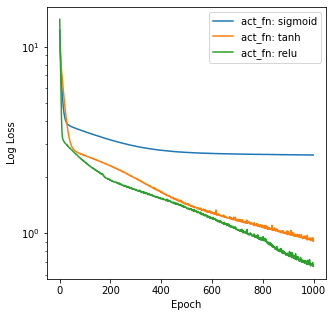

In [ ]:
# set seed to make example reproducible
torch.manual_seed(123)
Ni, No = 1, 1
hidden_layer_params = {0:25,1:25}
sig = nn.Sigmoid
tanh = nn.Tanh
relu = nn.ReLU
n_epochs = 1000

# define the multi-layer perceptron
loss_fn = nn.MSELoss() # MSE loss since regression

mlp_sig = MLP(Ni,No,hidden_layer_params,act_fn = sig)
mlp_tanh = MLP(Ni,No,hidden_layer_params,act_fn = tanh)
mlp_relu = MLP(Ni,No, hidden_layer_params, act_fn = relu)
optimiser_sig = optim.SGD(mlp_sig.parameters(), lr = 1e-3)
optimiser_tanh = optim.SGD(mlp_tanh.parameters(), lr = 1e-3)
optimiser_relu = optim.SGD(mlp_relu.parameters(), lr = 1e-3)
# train the model
train_loss_sig = run_training_reg(n_epochs, mlp_sig, optimiser_sig, loss_fn, device, train_loader)
train_loss_tanh = run_training_reg(n_epochs, mlp_tanh, optimiser_tanh, loss_fn, device, train_loader)
train_loss_relu = run_training_reg(n_epochs, mlp_relu, optimiser_relu, loss_fn, device, train_loader)
# plot training loss on full data
plt.figure(figsize = (5,5))
plt.semilogy(train_loss_sig, label = "act_fn: sigmoid")
plt.semilogy(train_loss_tanh, label = "act_fn: tanh")
plt.semilogy(train_loss_relu, label = 'act_fn: relu')
plt.ylabel("Log Loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("plots/act_fns.png", dpi = 300)
plt.show()

As expected the hyperbolic tangent activation function outperforms the sigmoid activation function. Thus, in the following I will only use the hyperbolic tangent. 

### Compare different optimisers

Initialising training


Finished training after 4 seconds
Initialising training


Finished training after 4 seconds
Initialising training


Finished training after 5 seconds
Initialising training


Finished training after 4 seconds


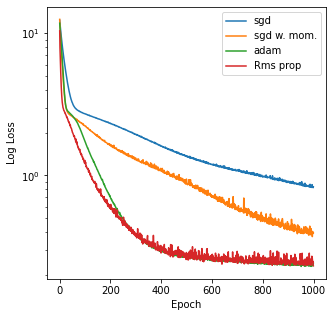

In [ ]:
# set seed to make example reproducible
torch.manual_seed(123)
Ni, No = 1, 1
hidden_layer_params = {0:25,1:25}
act_fn = nn.Tanh
n_epochs = 1000

# define the multi-layer perceptron
mlp = MLP(Ni,No,hidden_layer_params,act_fn)
loss_fn = nn.MSELoss() # MSE loss since regression

# define different optimisers
sgd = optim.SGD(mlp.parameters(), lr = 1e-3)
sgd_mom = optim.SGD(mlp.parameters(), lr = 1e-3, momentum = 0.5)
adam = optim.Adam(mlp.parameters(), lr = 1e-3)
rms = optim.RMSprop(mlp.parameters(), lr = 1e-3)

# train the model
train_loss_sgd = run_training_reg(n_epochs, mlp, sgd, loss_fn, device, train_loader)
mlp.apply(weight_reset)
train_loss_sgd_mom = run_training_reg(n_epochs, mlp, sgd_mom, loss_fn, device, train_loader)
mlp.apply(weight_reset)
train_loss_adam = run_training_reg(n_epochs,mlp, adam, loss_fn, device, train_loader)
mlp.apply(weight_reset)
train_loss_rms = run_training_reg(n_epochs, mlp, rms, loss_fn, device, train_loader)

# plot training loss on full data
plt.figure(figsize = (5,5))
plt.semilogy(train_loss_sgd, label = "sgd")
plt.semilogy(train_loss_sgd_mom, label = "sgd w. mom.")
plt.semilogy(train_loss_adam,label = 'adam')
plt.semilogy(train_loss_rms, label = 'Rms prop')
plt.ylabel("Log Loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("plots/optimisers.png")
plt.show()

### Compare different weight initialisation schemes

Initialising training


Finished training after 5 seconds
Initialising training


Finished training after 5 seconds
Initialising training


Finished training after 5 seconds


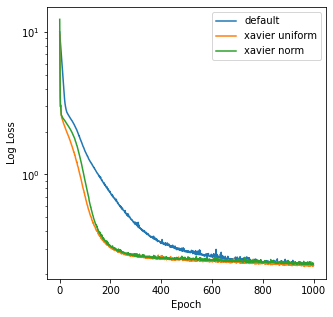

In [ ]:
# set seed to make example reproducible
torch.manual_seed(123)
Ni, No = 1, 1
hidden_layer_params = {0:25,1:25}
act_fn = nn.Tanh
n_epochs = 1000

# define the multi-layer perceptron
loss_fn = nn.MSELoss() # MSE loss since regression

mlp = MLP(Ni,No,hidden_layer_params,act_fn)
optimiser = optim.Adam(mlp.parameters(), lr = 1e-3)

# train the model
mlp.apply(weight_reset)
train_loss_def = run_training_reg(n_epochs, mlp, optimiser, loss_fn, device, train_loader)
mlp.apply(init_weights_xavier_unif)
train_loss_unif = run_training_reg(n_epochs, mlp, optimiser, loss_fn, device, train_loader)
mlp.apply(init_weights_xavier_norm)
train_loss_norm = run_training_reg(n_epochs, mlp, optimiser, loss_fn, device, train_loader)

# plot training loss on full data
plt.figure(figsize = (5,5))
plt.semilogy(train_loss_def, label = 'default')
plt.semilogy(train_loss_unif, label = 'xavier uniform')
plt.semilogy(train_loss_norm, label = "xavier norm")
plt.ylabel("Log Loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("plots/weight_init.png", dpi = 300)
plt.show()

### batch size

batch size: 1
Initialising training


Finished training after 91 seconds
batch size: 10
Initialising training


Finished training after 10 seconds
batch size: 20
Initialising training


Finished training after 5 seconds
batch size: 50
Initialising training


Finished training after 2 seconds
batch size: 100
Initialising training


Finished training after 1 seconds


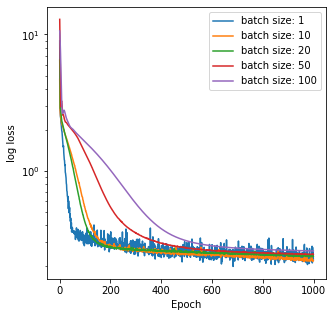

In [ ]:
Ni, No = 1,1
hidden_layer_params = {0:25,1:25}
act_fn = nn.Tanh
n_epochs = 1000

mlp = MLP(Ni,No,hidden_layer_params,act_fn)
optimiser = optim.Adam(mlp.parameters(), lr = 1e-3)

batches = [1,10,20,50,100]
batch_results = np.zeros((len(batches),n_epochs))

for it, batch_size in enumerate(batches):
  train_load = DataLoader(train_tensor, batch_size = batch_size, shuffle = True, num_workers = 0)
  mlp.apply(init_weights_xavier_unif)
  print(f"batch size: {batches[it]}")
  batch_results[it,:] = run_training_reg(n_epochs, mlp, optimiser, loss_fn, device, train_load)

# plot results
plt.figure(figsize = (5,5))
for it,loss in enumerate(batch_results):
  lab = "batch size: "+str(batches[it])
  plt.semilogy(loss,label = lab)
plt.ylabel("log loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("plots/batch_sizes.png", dpi = 300)
plt.show()

### Learning rate




Learning rate: 0.1
Initialising training


Finished training after 5 seconds
Learning rate: 0.01
Initialising training


Finished training after 5 seconds
Learning rate: 0.001
Initialising training


Finished training after 5 seconds
Learning rate: 0.0001
Initialising training


Finished training after 5 seconds


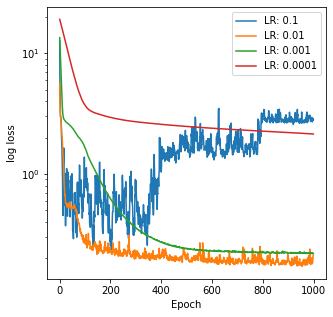

In [ ]:
train_loader = DataLoader(train_tensor, batch_size = 20, shuffle = True, num_workers = 0)
torch.manual_seed(123)
Ni, No = 1,1
hidden_layer_params = {0:25,1:25}
act_fn = nn.Tanh
n_epochs = 1000

lrs = [1e-1,1e-2,1e-3,1e-4]
lr_results = np.zeros((len(lrs),n_epochs))

mlp = MLP(Ni,No,hidden_layer_params,act_fn)
for it, lr in enumerate(lrs):
  mlp.apply(init_weights_xavier_unif)
  optimiser = optim.Adam(mlp.parameters(), lr = lr)
  print(f"Learning rate: {lrs[it]}")
  lr_results[it,:] = run_training_reg(n_epochs, mlp, optimiser, loss_fn, device, train_loader)

# plot results
plt.figure(figsize = (5,5))
for it,loss in enumerate(lr_results):
  lab = "LR: "+str(lrs[it])
  plt.semilogy(loss,label = lab)
plt.ylabel("log loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("plots/learning_rates.png", dpi = 300)
plt.show()

### Tune depth and width of network
The goal is to see how the generalisation error changes with the width and depth of the network.

In [ ]:
# first increase width of network (try out different parameters)
widths = [10,25,100,500]

torch.manual_seed(123)
act_fn = nn.Tanh
n_epochs = 1000
n_folds = 5

train_loss_width = np.zeros((len(widths), n_folds, n_epochs))
val_loss_width = np.zeros((len(widths), n_folds, n_epochs))

Ni, No = 1, 1
loss_fn = nn.MSELoss()
for it,width in enumerate(widths):
  print(f"--- width:{width}")
  hidden_layer_params = {0:width,1:width}
  mlp = MLP(Ni,No,hidden_layer_params,act_fn)
  train_loss_width[it,:,:], val_loss_width[it,:,:] = k_fold_cv(n_folds, train_df, n_epochs, mlp, device, init_weights_xavier_unif,
              optimiser = optim.Adam, learning_rate = 1e-3, batch_size=20, random_state = 123)

--- width:10
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 5 seconds

Completed Cross Validation after 25 seconds
--- width:25
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 5 seconds

Completed Cross Validation after 25 seconds
--- width:100
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 5 seconds

Completed Cross Validation after 27 seconds
--- width:500
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 16 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 16 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 16 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 16 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 15 seconds

Completed Cross Validation after 79 seconds


In [ ]:
plot_cv_hyper(train_loss_width,val_loss_width)

In [ ]:
# Check how depth of network influences the results
depths = [2,4,8,20]
torch.manual_seed(123)
act_fn = nn.Tanh
loss_fn = nn.MSELoss()
n_epochs = 1000
n_folds = 5
Ni, No = 1, 1

train_loss_depth = np.zeros((len(depths), n_folds, n_epochs))
val_loss_depth = np.zeros((len(depths), n_folds, n_epochs))

for it,depth in enumerate(depths):
  print(f"--- depth:{depth}")
  hidden_layer_params = dict(zip(list(range(depth)),np.repeat(25,depth)))
  mlp = MLP(Ni,No,hidden_layer_params, act_fn)
  train_loss_depth[it,:,:], val_loss_depth[it,:,:] = k_fold_cv(n_folds, train_df, n_epochs, mlp, device, init_weights_xavier_unif,
              optimiser = optim.Adam, learning_rate = 1e-3, batch_size=20, random_state = 123)

--- depth:2
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 5 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 5 seconds

Completed Cross Validation after 25 seconds
--- depth:4
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 7 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 7 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 7 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 7 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 7 seconds

Completed Cross Validation after 34 seconds
--- depth:8
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 10 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 10 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 10 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 10 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 10 seconds

Completed Cross Validation after 51 seconds
--- depth:20
Initialising Cross Validation

evaluating on fold 1 out of 5
Initialising training


Finished training after 20 seconds

evaluating on fold 2 out of 5
Initialising training


Finished training after 20 seconds

evaluating on fold 3 out of 5
Initialising training


Finished training after 21 seconds

evaluating on fold 4 out of 5
Initialising training


Finished training after 21 seconds

evaluating on fold 5 out of 5
Initialising training


Finished training after 21 seconds

Completed Cross Validation after 102 seconds


In [ ]:
plot_cv_hyper(train_loss_depth,val_loss_depth)

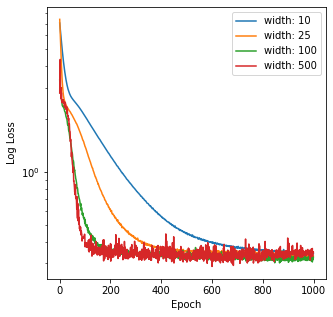

Comparing 4 models

Model	min loss	epoch	final loss
Model 0	0.3407	999		0.3407
Model 1	0.3213	974		0.3297
Model 2	0.3021	866		0.3240
Model 3	0.2884	600		0.3489


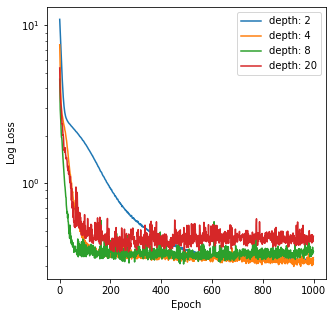

Comparing 4 models

Model	min loss	epoch	final loss
Model 0	0.3150	974		0.3248
Model 1	0.2964	922		0.3369
Model 2	0.3071	488		0.3697
Model 3	0.3659	227		0.4614


In [ ]:
# create plots for report
# width
avg_val_loss_w = np.mean(val_loss_width,axis = 1)
plt.figure(figsize = (5,5))
for it,loss in enumerate(avg_val_loss_w):
  lab = "width: "+str(widths[it])
  plt.semilogy(loss,label = lab)
plt.ylabel("Log Loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("plots/widths.png", dpi = 300)
plt.show()

get_best_mod(avg_val_loss_w)
# depth
avg_val_loss_d = np.mean(val_loss_depth, axis = 1)
plt.figure(figsize = (5,5))
for it,loss in enumerate(avg_val_loss_d):
  lab = 'depth: ' + str(depths[it])
  plt.semilogy(loss,label = lab)
plt.ylabel("Log Loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("plots/depths.png")
plt.show()
get_best_mod(avg_val_loss_d)

In [ ]:
# create a table comparing the losses 
width_tab = pd.DataFrame()
width_tab["width"] = widths
width_tab["depth"] = np.repeat(2,len(widths))
width_tab['min loss'] = np.min(avg_val_loss_w,axis = 1)
width_tab['epoch'] = np.argmin(avg_val_loss_w,axis = 1)

depth_tab = pd.DataFrame()
depth_tab['width'] = np.repeat(25,len(depths))
depth_tab['depth'] = depths
depth_tab['min loss'] = np.min(avg_val_loss_d,axis = 1)
depth_tab['epoch'] = np.argmin(avg_val_loss_d,axis = 1)

#width_tab.to_latex(float_format="%.4f",index = False, caption = "Network width", label = "tab:width")
#depth_tab.to_latex(float_format="%.4f",index = False, caption = "Network depth", label = "tab:depth")

'\\begin{table}\n\\centering\n\\caption{Network depth}\n\\label{tab:depth}\n\\begin{tabular}{rrrr}\n\\toprule\n width &  depth &  min loss &  epoch \\\\\n\\midrule\n    25 &      2 &    0.3150 &    974 \\\\\n    25 &      4 &    0.2964 &    922 \\\\\n    25 &      8 &    0.3071 &    488 \\\\\n    25 &     20 &    0.3659 &    227 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

In [ ]:
print(width_tab,'\n')
print(depth_tab)

   width  depth  min loss  epoch
0     10      2  0.340731    999
1     25      2  0.321332    974
2    100      2  0.302085    866
3    500      2  0.288385    600 

   width  depth  min loss  epoch
0     25      2  0.315041    974
1     25      4  0.296363    922
2     25      8  0.307068    488
3     25     20  0.365885    227


We see that increasing both, width and depth of networks increases their accuracy. However, the results suggest that this only holds up to a certain point: for instance a rather deep network with 20 layers actually yields higher cross-validation error than a more shallow network with only 4 hidden layers. Generally speaking, wider networks appear to converge faster than more narrow network, which intuitively makes sense as the network has more weights and thus it can be adapted to the data more quickly. Note moreover, that in both cases as I increase the width or depth of the network, the loss starts oscillating. We observe this because with increasing complexity of the model, the model becomes more and more overparameterised. Thus, for a more complex model it is sensible to introduce regularisation such as dropout or weight decay. From these results, it appears to be sensible to introduce a shallow network with only 4 layers and 100 hidden units each. I will use this model specification to explore the benefit of regularisation in the following.

### Overfitting the training data



In [ ]:
# uses same parameters as before, thus no need to specify
torch.manual_seed(123)

Ni, No = 1, 1
hidden_layer_params = {0:100,1:100,2:100,3:100}
act_fn = nn.Tanh
n_epochs = 3000
# specify number of folds for k-fold cv
n_folds = 5

# define the multi-layer perceptron
loss_fn = nn.MSELoss() # MSE loss since regression

# initialise model using the same hyper parameters defined above
mlp_cv = MLP(Ni,No,hidden_layer_params,act_fn)

train_loss_cv, val_loss_cv = k_fold_cv(n_folds, train_df, n_epochs, mlp_cv, device, init_weights_xavier_unif,
              optimiser = optim.Adam, learning_rate = 1e-3, batch_size=20, random_state = 123)

plot_cv_results(train_loss_cv,val_loss_cv)

In [ ]:
torch.manual_seed(123)

Ni, No = 1, 1
hidden_layer_params = {0:100,1:100,2:100,3:100}
act_fn = nn.Tanh
n_epochs = 3000

# define the multi-layer perceptron
loss_fn = nn.MSELoss() # MSE loss since regression
mlp = MLP(Ni,No,hidden_layer_params,act_fn)
mlp.apply(init_weights_xavier_unif)
optimiser = optim.Adam(mlp.parameters(),lr = 1e-3)

train_loss = run_training_reg(n_epochs,mlp,optimiser,loss_fn,device,train_loader)

Initialising training


Finished training after 25 seconds


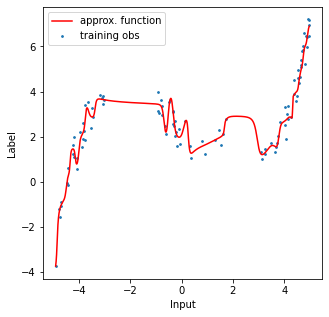

In [ ]:
y_hat = predict_reg(train_df.input,mlp,device)
x_new = np.linspace(min(train_df.input),max(train_df.input),10000)
y_hat_new = predict_reg(x_new,mlp,device)
# plot for report
plt.figure(figsize = (5,5))
plt.scatter(train_df.input,train_df.label,label = 'training obs', s = 3)
plt.plot(x_new,y_hat_new,label = 'approx. function', color = "red")
plt.legend()
plt.xlabel('Input')
plt.ylabel('Label')
plt.savefig("plots/overfit.png", dpi = 300)
plt.show()

### Regularise the model


In [ ]:
torch.manual_seed(123)

Ni, No = 1, 1
hidden_layer_params = {0:100,1:100,2:100,3:100}
act_fn = nn.Tanh
n_epochs = 3000
n_folds = 5

# define the grid
do = np.array([0,0.001,0.01,0.1,0.2])
wd = np.array([0,0.001,0.005,0.01,0.1])
# this has the dropout rate first and wd second
combs = np.array(np.meshgrid(do,wd)).T.reshape(-1,2)

train_loss_reg, val_loss_reg = np.zeros((len(combs),n_folds,n_epochs)), np.zeros((len(combs),n_folds,n_epochs))

for it, comb in enumerate(combs):
  print(f"--- combination {it} of {len(combs)}")
  mlp = MLP(Ni,No,hidden_layer_params, act_fn, dropout = comb[0])
  train_loss_reg[it,:,:], val_loss_reg[it,:,:] = k_fold_cv(n_folds, train_df, n_epochs, mlp, device, init_weights_xavier_unif,
              optimiser = optim.Adam, learning_rate = 1e-3, wd = comb[1],batch_size=20, random_state = 123)


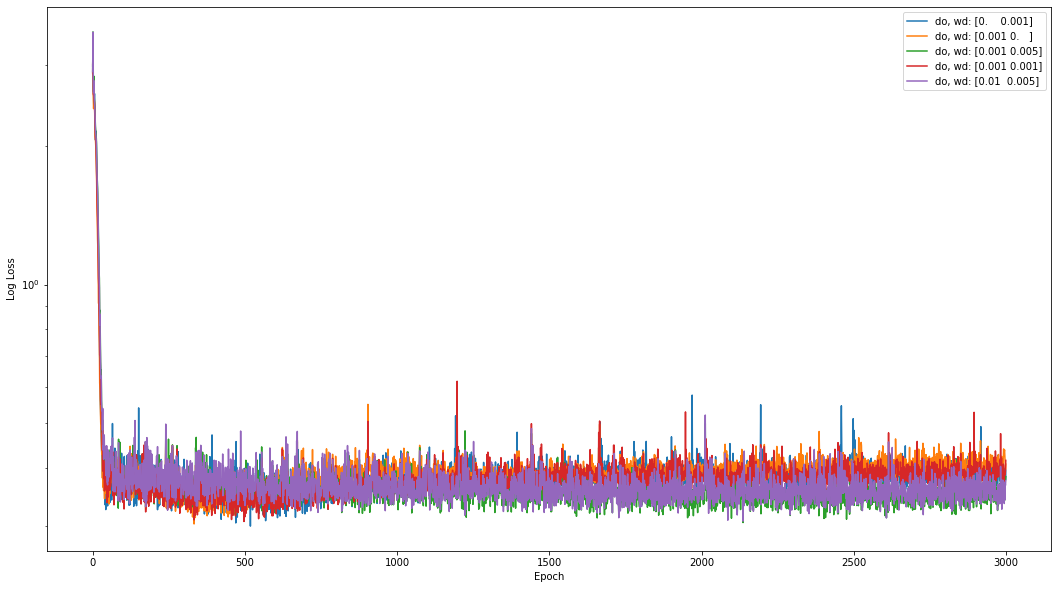

Comparing 5 models

Model	min loss	epoch	final loss
Model 0	0.2992	518		0.3780
Model 1	0.3024	333		0.4077
Model 2	0.3045	2136		0.3828
Model 3	0.3061	497		0.4155
Model 4	0.3067	2136		0.3754
The most accurate model is a model with DO = 0.0 and WD = 0.001


In [ ]:
# get the best model based on the lowest validation loss
regu_loss = np.mean(val_loss_reg, axis = 1)
# plot the 5 best performing combinations
best_idx = np.argsort(np.min(regu_loss,axis = 1))[:5]
best_combs = regu_loss[best_idx]

plt.figure(figsize = (18,10))
for it, loss in enumerate(best_combs):
  lab = "do, wd: " + str(combs[best_idx[it]])
  plt.semilogy(loss, label = lab)
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.legend()
plt.show()

get_best_mod(best_combs)
print(f"The most accurate model is a model with DO = {combs[best_idx[0]][0]} and WD = {combs[best_idx[0]][1]}")

tuned_do, tuned_wd = combs[best_idx[0]][0], combs[best_idx[0]][1] 

Thus the final model does not include any dropout. However, the minimum loss is smaller than the loss in the last period, which indicates that the model overfits with increasing periods.

In [ ]:
tuned_epoch = np.argmin(best_combs[0])
final_train_loss = np.mean(train_loss_reg,axis = 1)[best_idx[0]][tuned_epoch]

print(f"The final model\n")
print(f"Hidden Layers \t {len(hidden_layer_params)}")
print(f"Hidden Units \t {hidden_layer_params[0]}")
print(f"Activation fn \t Tanh")
print(f"N epochs \t {tuned_epoch}")
print(f"Optimiser \t Adam")
print(f"Learning rate \t {1e-3}")
print(f"Batch size \t {20}")
print(f"Weight init \t Xavier uniform")
print(f"Dropout rate \t {tuned_do}")
print(f"Weight decay \t {tuned_wd}\n")
print("-------------------------------")
print(f"Final train loss \t {final_train_loss:.4f}")
print(f"Final val loss \t\t {np.min(best_combs[0]):.4f}")

The final model

Hidden Layers 	 4
Hidden Units 	 100
Activation fn 	 Tanh
N epochs 	 518
Optimiser 	 Adam
Learning rate 	 0.001
Batch size 	 20
Weight init 	 Xavier uniform
Dropout rate 	 0.0
Weight decay 	 0.001

-------------------------------
Final train loss 	 0.2243
Final val loss 		 0.2992


### Fit the final model
Fit the final model on the full data and comapre to test set.

In [ ]:
torch.manual_seed(123)

Ni, No = 1, 1
hidden_layer_params = {0:100,1:100,2:100,3:100}
act_fn = nn.Tanh
n_epochs = tuned_epoch

# define the multi-layer perceptron
loss_fn = nn.MSELoss() # MSE loss since regression
mlp_final = MLP(Ni,No,hidden_layer_params,act_fn,dropout = tuned_do)
mlp_final.apply(init_weights_xavier_unif)
optimiser = optim.Adam(mlp_final.parameters(),lr = 1e-3,weight_decay=tuned_wd)

train_loss = run_training_reg(n_epochs,mlp_final,optimiser,loss_fn,device,train_loader)

Initialising training


Finished training after 5 seconds


In [ ]:
y_hat = predict_reg(train_df.input,mlp_final,device)
x_new = np.linspace(min(train_df.input),max(train_df.input),10000)
y_hat_new = predict_reg(x_new,mlp_final,device)

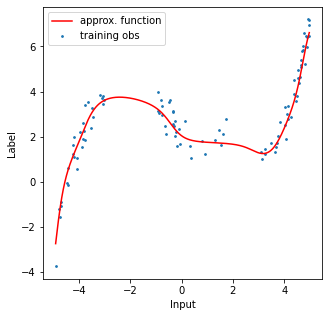

In [ ]:
# plot for report
plt.figure(figsize = (5,5))
plt.scatter(train_df.input,train_df.label,label = 'training obs', s = 3)
plt.plot(x_new,y_hat_new,label = 'approx. function', color = "red")
plt.legend()
plt.xlabel('Input')
plt.ylabel('Label')
plt.savefig("plots/final_model.png", dpi = 300)
plt.show()

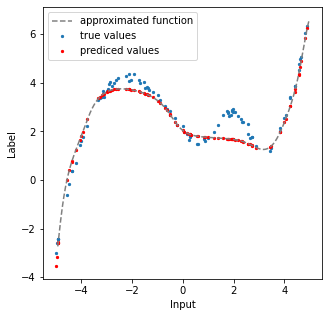

In [ ]:
y_hat = predict_reg(test_df.input,mlp_final,device)
x_new = np.linspace(min(train_df.input),max(train_df.input),10000)
y_hat_new = predict_reg(x_new,mlp_final,device)

plt.figure(figsize = (5,5))
plt.plot(x_new,y_hat_new,label = 'approximated function', color = 'grey', linestyle = "--")
plt.scatter(test_df.input,test_df.label,label = "true values", s = 5)
plt.scatter(test_df.input,y_hat, label = 'prediced values', color = 'red', s = 5)
plt.legend()
plt.xlabel("Input")
plt.ylabel("Label")
plt.savefig("plots/final_prediction.png", dpi = 300)
plt.show()

In [ ]:
def mse(y_hat,y):
  diff = y - y_hat
  out = 1/len(y) * diff.T@diff
  return out
mse(y_hat,test_df.label)

0.24323608986355272

### Plot network parameters of the final model


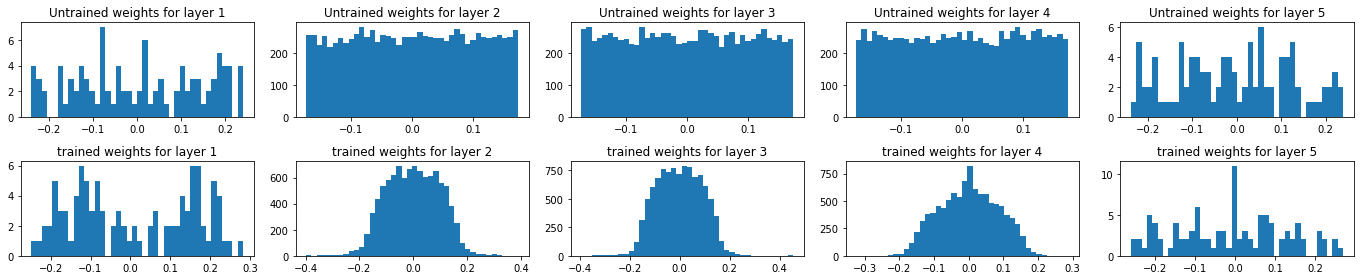

In [ ]:
# plot weights for untrained and for final model
torch.manual_seed(123)
Ni, No = 1, 1
hidden_layer_params = {0:100,1:100,2:100,3:100}
act_fn = nn.Tanh
untrained_mlp = MLP(Ni, No, hidden_layer_params,act_fn)
untrained_mlp.apply(init_weights_xavier_unif)

# get untrained weights
untrained_weights = []
for layer in untrained_mlp.layers:
  if isinstance(layer,torch.nn.modules.linear.Linear):
    untrained_weights.append(layer.weight.data.cpu().numpy())

# get trained weights
weights = []
for layer in mlp_final.layers:
  if isinstance(layer,torch.nn.modules.linear.Linear):
    weights.append(layer.weight.data.cpu().numpy())

# plots all weights in one plot
fig, ax = plt.subplots(2,len(weights),figsize = (19,4))
for j in range(len(weights)):
  ax[0,j].hist(untrained_weights[j].flatten(),40)
  ax[0,j].set_title(f"Untrained weights for layer {j+1}")
  ax[1,j].hist(weights[j].flatten(),40)
  ax[1,j].set_title(f"trained weights for layer {j+1}")
plt.tight_layout()
plt.savefig("plots/weights.png", dpi = 300)
plt.show()


In [ ]:
# Get activations of network
acts = {}
def get_activation(name):
  def hook(layer,input,output):
    acts[name] = output.detach().cpu().numpy()
  return hook

# create array to save activations for different inputs
acts_last = []
# register hook
hook_last = mlp_final.layers[1].register_forward_hook(get_activation("last"))
mlp.eval()
with torch.no_grad():
  x1 = torch.tensor([-3]).float()
  y1 = mlp_final(x1.to(device))
  acts_last.append(acts["last"])

  x2 = torch.tensor([3]).float()
  y2 = mlp_final(x2.to(device))
  acts_last.append(acts["last"])

  x3 = torch.tensor([10]).float()
  y3 = mlp_final(x3.to(device))
  acts_last.append(acts["last"])

hook_last.remove()

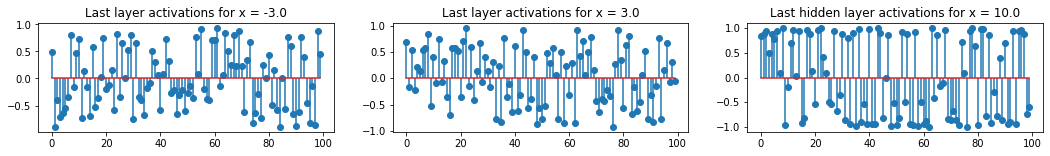

In [ ]:
fig, ax = plt.subplots(1, 3, figsize = (18,2))
ax[0].stem(acts_last[0].reshape(-1),use_line_collection = True)
ax[0].set_title(f"Last layer activations for x = {x1.numpy()[0]}")
ax[1].stem(acts_last[1].reshape(-1),use_line_collection = True)
ax[1].set_title(f"Last layer activations for x = {x2.numpy()[0]}")
ax[2].stem(acts_last[2].reshape(-1),use_line_collection = True)
ax[2].set_title(f"Last hidden layer activations for x = {x3.numpy()[0]}")
plt.savefig('plots/activations.png', dpi = 300)
plt.show()

# Second Task - Classification


## Load the data

In [10]:
# load the data
transform = torchvision.transforms.ToTensor()
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True, download=True, transform = transform)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform = transform)

In [11]:
lab_dict = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat", 
    5: "Sandal", 
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

## Plot the data

In [ ]:
# get all different labels
print(f"There are {len(torch.unique(train_dataset.targets))} different labels")
print(f"These are {torch.unique(train_dataset.targets)}")

# get the size of the images
print(f"Each input is of size {train_dataset[0][0].size()} pixels")

There are 10 different labels
These are tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Each input is of size torch.Size([1, 28, 28]) pixels


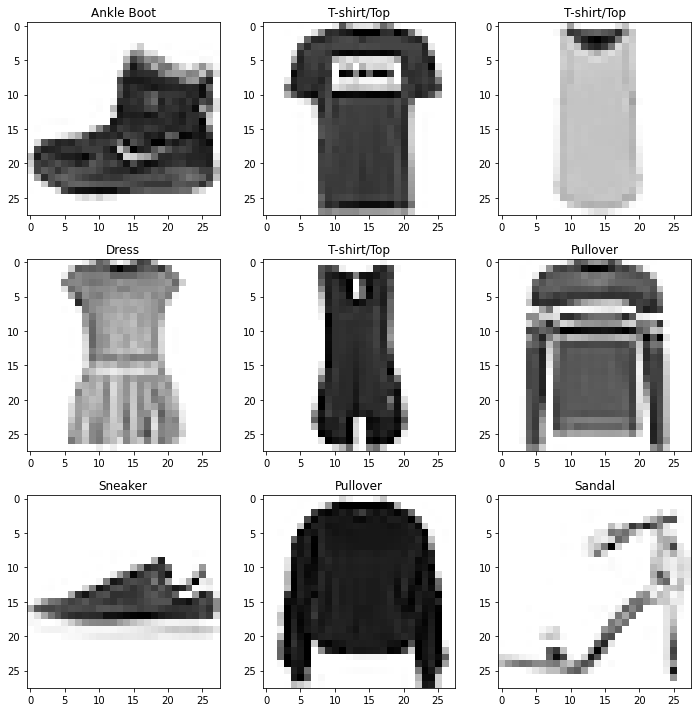

In [ ]:
# first plot the first 9 images in a grid
plt.figure(figsize = (10,10))
for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(train_dataset[i][0].view(28,28), cmap="Greys")
  plt.title(lab_dict[train_dataset[i][1]])
plt.tight_layout()
plt.show()

## Preprocess the data


In [12]:
# train_dataset.data = train_dataset.data[:100]
# train_dataset.targets = train_dataset.targets[:100]

In [13]:
# create a validation set, since the dataset is relatively large. Training, validation split is 80 - 20.
torch.manual_seed(123)
np.random.seed(123)

batch_size = 256

train_dataset, val_dataset = split_data(train_dataset,val_size = 0.2)

train_loader = DataLoader(train_dataset,batch_size = batch_size,shuffle = True,num_workers = 0)
val_loader = DataLoader(val_dataset,batch_size = batch_size,shuffle = False,num_workers = 0)
test_loader = DataLoader(test_dataset,batch_size = batch_size,shuffle = False,num_workers = 0)

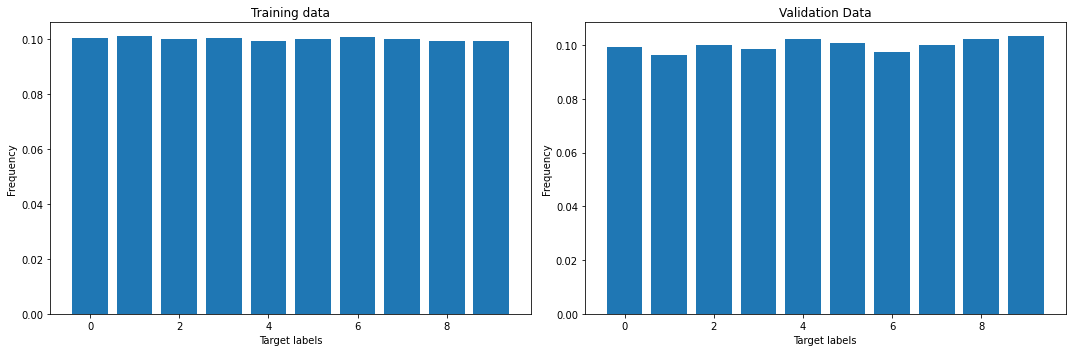

In [14]:
# check distribution of labels in the training and validation set
class_count_train = count_classes(train_dataset)
class_count_val = count_classes(val_dataset)

plt.figure(figsize = (15,5))
plt.subplot(121)
plt.bar(x = range(10),height = class_count_train)
plt.xlabel("Target labels")
plt.ylabel("Frequency")
plt.title("Training data")

plt.subplot(122)
plt.bar(x = range(10),height = class_count_val)
plt.xlabel("Target labels")
plt.ylabel("Frequency")
plt.title("Validation Data")

plt.tight_layout()
plt.savefig("plots/validation_split.png", dpi = 500)
plt.show() 

## Multi Layer Perceptron

### Simple network with SGD

In [ ]:
torch.manual_seed(123)
Ni = 28*28
No = 10
hidden_layer_params = {0:1024,1:1024,2:512,3:128}
act_fn = nn.ReLU # set the activation function
n_epochs = 100

mlp_cl = MLP(Ni,No,hidden_layer_params,act_fn)

loss_fn = nn.CrossEntropyLoss() # cross entropy loss since it is a classification
optimiser = optim.SGD(mlp_cl.parameters(), lr= 1e-2) # SGD

train_loss, train_acc, val_loss, val_acc = run_training_cl(n_epochs,mlp_cl,optimiser,loss_fn,device,
                          train_loader = train_loader, val_loader = val_loader)

# save results
cl_mlp_sgd_res = [train_loss, train_acc, val_loss, val_acc]
np.save('results/cl_mlp_sgd_res.npy',cl_mlp_sgd_res)

Initialising training


Finished training after 1751 seconds


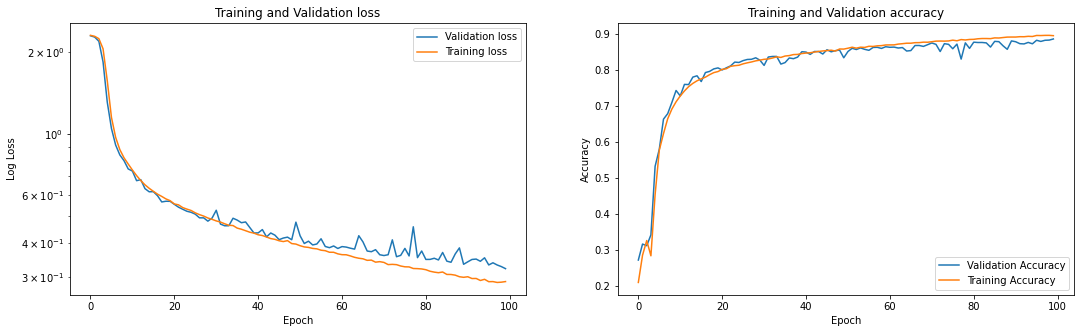

The model achieved the lowest validation loss in epoch 99: 0.321923
The model achieved the highest validation accuracy in epoch 99: 0.886333
Validation loss in last epoch 0.321923
Validation accuracy in last epoch 0.886333
The network has 2445194 parameters to train.


In [ ]:
plot_class_results(train_loss, train_acc, val_loss, val_acc)
get_best_period(val_loss,val_acc)
print(f"Validation loss in last epoch {val_loss[-1]:6f}")
print(f"Validation accuracy in last epoch {val_acc[-1]:6f}")
print(f"The network has {get_n_params(mlp_cl)} parameters to train.")

The training loss and validation loss are very similar. Training is slow the model only starts overfitting towards the end of training. Thus introduce Adam optimiser and Kaiming weight init, which should increase the speed of loss convergence.



### Introduce Adam and Kaiming weight initialisation


In [ ]:
torch.manual_seed(123)
Ni = 28*28
No = 10
hidden_layer_params = {0:1024,1:1024,2:512,3:128}
act_fn = nn.ReLU # set the activation function
max_epochs = 100

mlp_cl = MLP(Ni,No,hidden_layer_params,act_fn)
mlp_cl.apply(init_weights_kaiming) # add weight initialisation to increase speed of convergence

loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(mlp_cl.parameters(), lr= 1e-3)

train_loss_ad, train_acc_ad, val_loss_ad, val_acc_ad = run_training_cl(max_epochs,mlp_cl,optimiser,loss_fn,device,
                          train_loader = train_loader, val_loader = val_loader,early_stopper = None)
# save results
cl_mlp_ad_res = [train_loss_ad, train_acc_ad, val_loss_ad, val_acc_ad]
np.save('results/cl_mlp_ad_res.npy',cl_mlp_ad_res)

Initialising training


Finished training after 2636 seconds


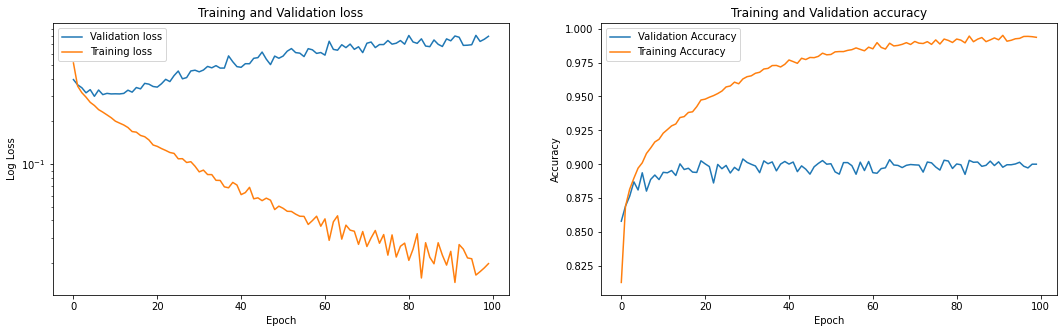

The model achieved the lowest validation loss in epoch 5: 0.300255
The model achieved the highest validation accuracy in epoch 29: 0.903917
Validation loss in last epoch 0.795590
Validation accuracy in last epoch 0.900083
The network has 2445194 parameters to train.


In [ ]:
plot_class_results(train_loss_ad, train_acc_ad, val_loss_ad, val_acc_ad)
get_best_period(val_loss_ad, val_acc_ad)
print(f"Validation loss in last epoch {val_loss_ad[-1]:6f}")
print(f"Validation accuracy in last epoch {val_acc_ad[-1]:6f}")
print(f"The network has {get_n_params(mlp_cl)} parameters to train.")

Training was too long and the model starts overfitting the training data. Moreover, stopping earlier would have saved computing times.Furthermore, the training and validation loss start oscillating quite strongly with increasing number of epochs. Thus, it might prove useful to explore different learning rates and batch sizes. 

### Early stopping and patience
Early stopping enables efficient training in order to reduce overfitting on the one hand and save computational cost on the other hand. However this also introduces the additional hyper-parameter patience, which is the number of epochs in which the model's validation accuracy does not increase before stopping training. I explore how the patience parameter affefcts training. To explore how different values of patience affect the models validation accruacy, I imitate its behavior on loss from the model trained with Adam and kaiming initialisation.


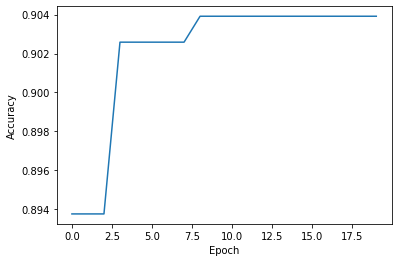

In [ ]:
def imitate_early_stop(acc,patience):
  best_acc = 0
  best_epoch = 0
  epoch = 0
  pat = 0
  while pat <= patience:
    if acc[epoch] > best_acc:
      best_acc = acc[epoch]
      best_epoch = epoch
      pat = 0
    else:
      pat += 1
    epoch += 1
    if epoch == len(acc):
      break
  return best_acc, best_epoch
  
pats = np.linspace(1,20,20,dtype = "int")
pats_acc = []
for patience in pats:
  pats_acc.append(imitate_early_stop(val_acc_ad,patience)[0])

plt.plot(pats_acc)
plt.xlabel("Patience")
plt.ylabel("Validation Accuracy")
plt.show()

The plot shows that setting the patience parameter too low avoids achieving the maximum accuracy on the validation set for the particular setup. If patience is set too low, the model stops too early. In contrast, choosing a high value for the patience parameter, results in the model training in vain. In the following I use a patience of 10 to train models.

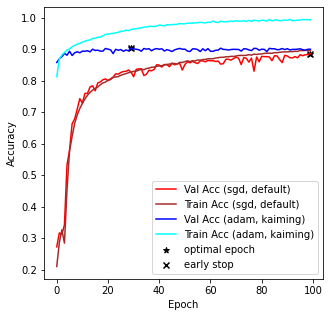

Highest validation accuracies for both appoaches

SGD, Default weight init 	 0.8863, epoch 99
Adam, Kaiming weight init 	 0.9039, epoch 29
Eraly stop validation accuracies for both appoaches

SGD, Default weight init 	 0.8863, epoch 99
Adam, Kaiming weight init 	 0.9039, epoch 29


In [ ]:
# load results
train_loss, train_acc, val_loss, val_acc = np.load('results/cl_mlp_sgd_res.npy')
train_loss_ad, train_acc_ad, val_loss_ad, val_acc_ad = np.load('results/cl_mlp_ad_res.npy')

# plot results for the report

opt_epochs = np.argmax(val_acc), np.argmax(val_acc_ad)
opt_acc = np.max(val_acc), np.max(val_acc_ad)
early_stop_epochs = imitate_early_stop(val_acc,patience = 10)[1], imitate_early_stop(val_acc_ad,patience = 10)[1]
early_stop_acc = imitate_early_stop(val_acc,patience = 10)[0], imitate_early_stop(val_acc_ad,patience = 10)[0]

plt.figure(figsize = (5,5))
plt.plot(val_acc, label = "Val Acc (sgd, default)", color = "red")
plt.plot(train_acc, label = "Train Acc (sgd, default)", color = 'brown')
plt.plot(val_acc_ad, label = "Val Acc (adam, kaiming)", color = "blue")
plt.plot(train_acc_ad, label = "Train Acc (adam, kaiming)", color = 'cyan')
plt.scatter(x = opt_epochs, y = opt_acc, marker = '*', color = "black", label = "optimal epoch")
plt.scatter(x = early_stop_epochs, y = early_stop_acc, marker = 'x', color = "black", label = "early stop" )

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig("plots/cl_simple.png", dpi = 500)
plt.show()

print(f"Highest validation accuracies for both appoaches\n")
print(f"SGD, Default weight init \t {opt_acc[0]:.4f}, epoch {opt_epochs[0]}")
print(f"Adam, Kaiming weight init \t {opt_acc[1]:.4f}, epoch {opt_epochs[1]}")

print(f"Eraly stop validation accuracies for both appoaches\n")
print(f"SGD, Default weight init \t {early_stop_acc[0]:.4f}, epoch {early_stop_epochs[0]}")
print(f"Adam, Kaiming weight init \t {early_stop_acc[1]:.4f}, epoch {early_stop_epochs[1]}")

Introducing the Adam optimiser togehter with Kaiming weight initialisation speeds up the convergence of the model substantially and also increases the accuracy of the model on the validation set. In fact, a model with SGD and default weight initialisation does not even reach the validation accuracy that the former model achieves after training for only one epoch.

### Hyper-parameter optimisation
To regularise the model and prevent overfitting I also introduce weight decay and dropout after each hidden layer. This introduces two additional hyper-paramters to tune (the penalty for weight decay and the dropout rate). All together, there are 6 hyper-parameters to tune in the present model: The width and depth of the neural network, the learning rate, the batch size as well as the penalty for weight decay and the dropout rate. I find it most instructive to restrict the parameter space for each hyper-parameter to some sensible subspace and then optimise the hyper-parameters relying on random search.
In particular, I focus on two different network definitions (a shallow and a deep network), learning rate $\in [0.001,0.0001]$, batch size $\in \{64,128,256,512\}$, $dropout~rate \in [0.2,0.8]$, $alpha \in [0,0.2]$.
All networks use the Adam optimiser, the ReLU activation function, Kaiming weight initialisation and early stopping.

In [ ]:
torch.manual_seed(123)
np.random.seed(123)
Ni,No = 28*28, 10
act_fn = nn.ReLU
loss_fn = nn.CrossEntropyLoss()
max_epochs = 100

net_depths = [{0:1024,1:1024,2:512,3:128},{0:1024,1:1024,2:1024,3:1024,4:512,5:512,6:128,7:128}]
batch_sizes = [64,128,256,512]

n_models = 6
net_definitions = []
train_loss_hyp = np.zeros((n_models,max_epochs)) * np.nan
train_acc_hyp = np.zeros((n_models,max_epochs)) * np.nan
val_loss_hyp = np.zeros((n_models,max_epochs)) * np.nan
val_acc_hyp = np.zeros((n_models,max_epochs)) * np.nan

for j in range(n_models):
  # first randomly sample the network architecture
  hidden_layer_params = np.random.choice(net_depths,1)[0]
  batch = int(np.random.choice(batch_sizes,1)[0])
  lr = float(np.random.uniform(1e-4,1e-3,1))
  # try out 2 models with only dropout 
  if j < 2: 
    do_rate = float(np.random.uniform(0.2,0.8,1))
    alpha = 0
  elif j < 4:
    do_rate = 0
    alpha = float(np.random.uniform(0,1e-1,1))
  else: 
    # choose both small as combining them increases their strength exponentially
    do_rate = float(np.random.uniform(1e-2,0.2,1))
    alpha = float(np.random.uniform(0,1e-2))
  # create training dataloader in correct batch size
  train_loader_hyp = DataLoader(train_dataset,batch_size = batch,shuffle = True,num_workers = 0)

  # store the network definition 
  net_definitions.append([hidden_layer_params,batch,lr,do_rate,alpha])
  
  # tune the model, save parameters and results
  mod_path = "cl_checkpoints/mlp_hyp_"+str(j)+".pt"

  mlp_hyp = MLP(Ni,No,hidden_layer_params,act_fn,dropout = do_rate)
  mlp_hyp.apply(init_weights_kaiming)

  optimiser = optim.Adam(mlp_hyp.parameters(), lr = lr, weight_decay = alpha)

  early_stopper = EarlyStopper(path=mod_path, patience=10)
  print(f"\n---- train model on hyper_parameter combination {j}")
  print([hidden_layer_params,batch,lr,do_rate,alpha])
  train_loss, train_acc, val_loss, val_acc = run_training_cl(max_epochs,mlp_hyp,optimiser,loss_fn,device,
                          train_loader = train_loader_hyp, val_loader = val_loader, early_stopper = early_stopper)
  n_epc = len(train_loss)
  train_loss_hyp[j,:n_epc], train_acc_hyp[j,:n_epc], val_loss_hyp[j,:n_epc], val_acc_hyp[j,:n_epc] = train_loss, train_acc, val_loss, val_acc

# save hyper-parameter optimisation results
cl_mlp_hyp_res = [train_loss_hyp,train_acc_hyp,val_loss_hyp,val_acc_hyp]
np.save("results/cl_mlp_hyp_res.npy",cl_mlp_hyp_res)
np.save("results/cl_mlp_hyp_net_definitions.npy",net_definitions)

print("\n----------------------------")
print("loading the model with the highest validation accuracy")
best_model = np.argmax(np.nanmax(val_acc_hyp,axis = 1))
np.save("results/cl_mlp_hyp_best_model.npy",best_model)
best_model_path = "cl_checkpoints/mlp_hyp_"+str(best_model)+".pt"

# load checkpoint
hidden_layer_params = net_definitions[best_model][0]
do_rate = net_definitions[best_model][3]

mlp_hyp = MLP(Ni,No,hidden_layer_params,act_fn, dropout = do_rate)
mlp_hyp.load_state_dict(torch.load(best_model_path,map_location = device))
print("model","hidden layer parameters,","batch size,", "learning rate,", "dropout rate,", 'alpha')
print("model",str(best_model),":",net_definitions[best_model])

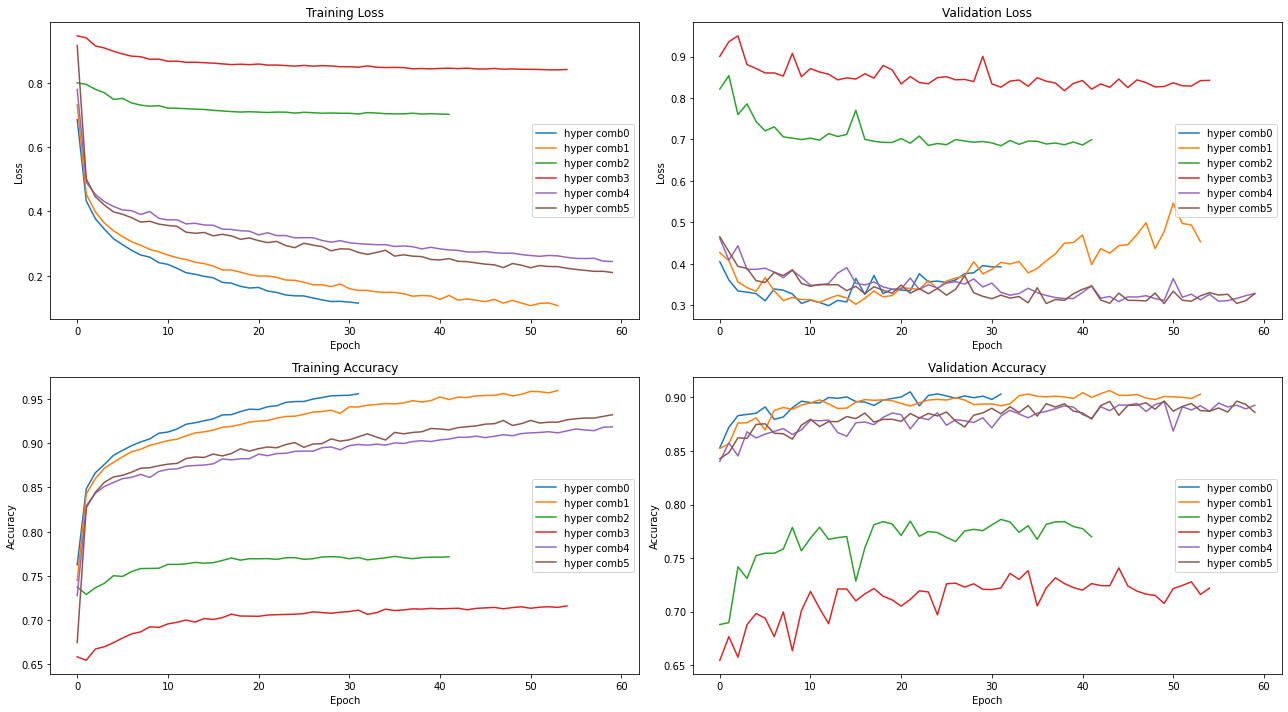

In [17]:
plot_class_hyper(train_loss_hyp,train_acc_hyp,val_loss_hyp,val_acc_hyp)

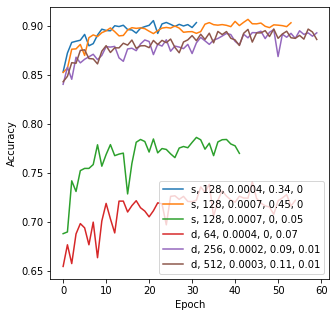

In [18]:
# create plot for report
plt.figure(figsize = (5,5))
for it, acc in enumerate(val_acc_hyp):
  net_def = net_definitions[it]
  if len(net_def[0]) < 8:
    depth = 's'
  else: 
    depth = 'd'
  lab = depth + ", " + str(net_def[1]) + ", " + str(round(net_def[2],4)) + ", " + str(round(net_def[3],2)) + ", " + str(round(net_def[4],2))
  plt.plot(acc,label = lab)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc = 'lower right')
plt.savefig("plots/cl_mlp_hyp.png",dpi = 500)
plt.show()

We see that the validation accuracy follows much more the training accuracy than before, which indicates less overfitting of the model. Indeed, the model achieves a even higher validation accuracy compared to the model without dropout. However, the model might react differntly to different dropout rates. Thus, I will compare model performance using different dropout rates.

## Convolutional Neural Network

### Define ConvNet
Three convolutional layers, three fully connected layers, ReLU, batch normalisation and maxpooling in the two last conv layers. Moreover, on the two first fcs introduce dropout with differing strength. 

In [ ]:
class ConvNet(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
                                nn.BatchNorm2d(32),
                                nn.ReLU())
    self.conv2 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
                                nn.BatchNorm2d(64),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size = 2, stride = 2))
    self.conv3 = nn.Sequential(nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 0),
                               nn.BatchNorm2d(64),
                               nn.ReLU(),
                               nn.MaxPool2d(kernel_size = 2, stride = 2))
    self.fc1 = nn.Sequential(nn.Linear(in_features = 64*6*6, out_features = 28*28),
                             nn.Dropout2d(0.25),
                             nn.ReLU())
    self.fc2 = nn.Sequential(nn.Linear(in_features = 28*28, out_features = 128),
                             nn.Dropout2d(0.15),
                             nn.ReLU())
    self.fc3 = nn.Linear(in_features = 128, out_features = 10)
  
  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.conv3(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

### Train ConvNet
train the convolutional network with early stopping, kaiming weight init, Adam optimiser with default learning rate. Save the network so I can load it later. This avoids training every time.

In [ ]:
torch.manual_seed(123)
max_epochs = 100

conv_net = ConvNet()
conv_net.apply(init_weights_kaiming)

loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(conv_net.parameters(), lr= 1e-3)

early_stopper = EarlyStopper(path='cl_checkpoints/cl_conv_checkpoint.pt', patience=10)
train_loss_conv, train_acc_conv, val_loss_conv, val_acc_conv = run_training_cl(max_epochs,conv_net,optimiser,loss_fn,device,
                          train_loader = train_loader, val_loader = val_loader, early_stopper = early_stopper)
conv_net_res = np.array([train_loss_conv, train_acc_conv, val_loss_conv, val_acc_conv])
np.save("results/conv_net_res.npy",conv_net_res)

Initialising training


Loading the best model...
Validation loss 0.294798
Validation accuracy 0.933500
Patience exhausted. Stopping early...
Finished training after 711 seconds


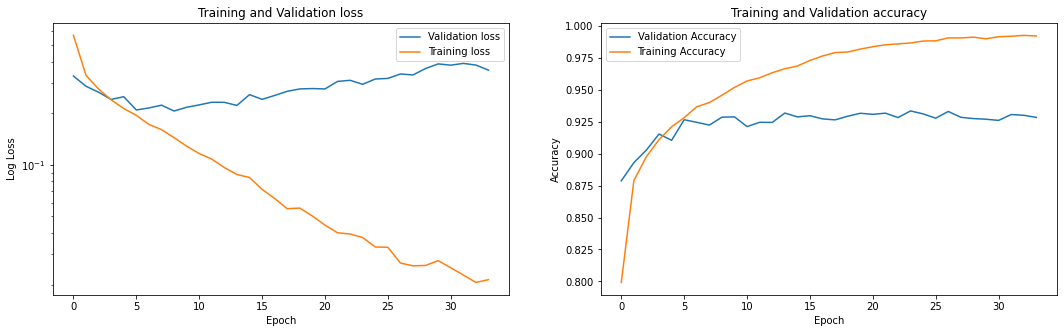

In [ ]:
plot_class_results(train_loss_conv, train_acc_conv, val_loss_conv, val_acc_conv)

### Introduce data augmentation


In [ ]:
transform_aug = torchvision.transforms.Compose(
    [torchvision.transforms.RandomRotation(20),
    torchvision.transforms.RandomHorizontalFlip(1),
    torchvision.transforms.ToTensor()]
)
train_dataset_aug = torchvision.datasets.FashionMNIST('classifier_data_aug', train=True, download=True, transform = transform_aug)
# get same train-test split as before
torch.manual_seed(123)
np.random.seed(123)

batch_size = 256

train_dataset_aug, val_dataset_aug = split_data(train_dataset_aug,val_size = 0.2)
train_dataset_aug = torch.utils.data.ConcatDataset([train_dataset,train_dataset_aug])
print(len(train_dataset_aug))
train_loader = DataLoader(train_dataset_aug,batch_size = batch_size,shuffle = True,num_workers = 0)

96000


In [ ]:
# fit the same conv network
torch.manual_seed(123)
max_epochs = 100

conv_net_aug = ConvNet()
conv_net_aug.apply(init_weights_kaiming)

loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(conv_net_aug.parameters(), lr= 1e-3)

early_stopper = EarlyStopper(path='cl_checkpoints/cl_conv_aug_checkpoint.pt', patience=10)
train_loss_aug, train_acc_aug, val_loss_aug, val_acc_aug = run_training_cl(max_epochs,conv_net_aug,optimiser,loss_fn,device,
                          train_loader = train_loader, val_loader = val_loader, early_stopper = early_stopper)
conv_net_aug_res = np.array([train_loss_aug, train_acc_aug, val_loss_aug, val_acc_aug])
np.save("results/conv_net_aug_res.npy",conv_net_aug_res)


Initialising training


Loading the best model...
Validation loss 0.242498
Validation accuracy 0.941333
Patience exhausted. Stopping early...
Finished training after 1677 seconds


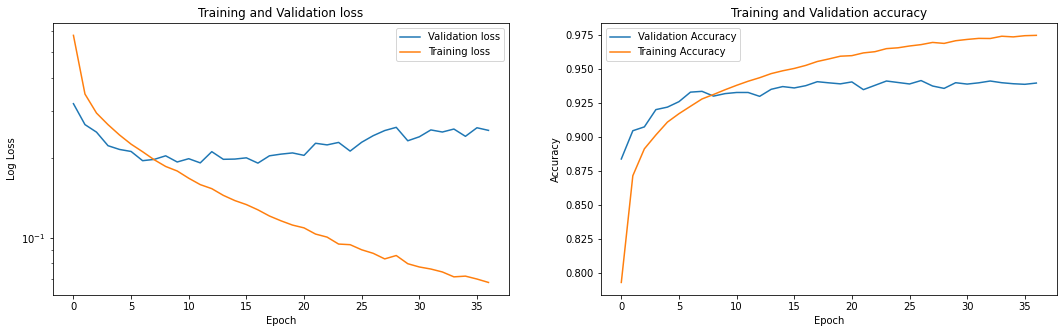

In [ ]:
plot_class_results(train_loss_aug, train_acc_aug, val_loss_aug, val_acc_aug)

## Compare models and select final model

[]

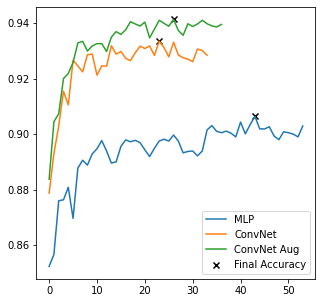

In [ ]:
# load losses
train_loss_hyp,train_acc_hyp,val_loss_hyp,val_acc_hyp = np.load("results/cl_mlp_hyp_res.npy")
train_loss_conv, train_acc_conv, val_loss_conv, val_acc_conv = np.load("results/conv_net_res.npy")
train_loss_aug, train_acc_aug, val_loss_aug, val_acc_aug = np.load("results/conv_net_aug_res.npy")

# best model from hyper parameter search (MLP)
best_model_hyp = np.load("results/cl_mlp_hyp_best_model.npy")

# get early stop periods
max_hyp = np.nanargmax(val_acc_hyp[best_model_hyp])
early_stop_epoch = max_hyp, np.argmax(val_acc_conv), np.argmax(val_acc_aug)
early_stop_acc = np.nanmax(val_acc_hyp[best_model_hyp]), np.max(val_acc_conv), np.max(val_acc_aug)

plt.figure(figsize = (5,5))
plt.plot(val_acc_hyp[best_model_hyp], label = 'MLP')
plt.plot(val_acc_conv, label = "ConvNet")
plt.plot(val_acc_aug, label = "ConvNet Aug")
plt.scatter(early_stop_epoch,early_stop_acc,marker = "x",color = "black", label = "Final Accuracy")
plt.legend()
plt.savefig("plots/cl_model_comparison.png",dpi = 500)
plt.plot()

In [ ]:
# load different models

# MLP
best_model_path = "cl_checkpoints/mlp_hyp_"+str(best_model_hyp)+".pt"

# load checkpoint
net_definitions = np.load('results/cl_mlp_hyp_net_definitions.npy', allow_pickle=True)
hidden_layer_params = net_definitions[best_model_hyp][0]
do_rate = net_definitions[best_model_hyp][3]

mlp_hyp = MLP(28*28,10,hidden_layer_params,nn.ReLU, dropout = do_rate)
mlp_hyp.load_state_dict(torch.load(best_model_path))

# CONV NET
conv_net = ConvNet()
state_conv_net = torch.load("cl_checkpoints/cl_conv_checkpoint.pt", map_location = device)
conv_net.load_state_dict(state_conv_net)

# CONV net with augmented data
conv_net_aug = ConvNet()
state_conv_net_aug = torch.load("cl_checkpoints/cl_conv_aug_checkpoint.pt", map_location = device)
conv_net_aug.load_state_dict(state_conv_net_aug)

<All keys matched successfully>

In [ ]:
# get predictions for each model
classes = list(lab_dict.values())
preds = []
mlp_hyp.to(device)
preds.append(predict_cl(val_loader, mlp_hyp, device))
conv_net.to(device)
preds.append(predict_cl(val_loader, conv_net, device))
conv_net_aug.to(device)
preds.append(predict_cl(val_loader, conv_net_aug, device))

In [ ]:
mods = ["MLP",'ConvNet',"ConvNet Aug"]
for it, pred in enumerate(preds):
  print("\n--------------------------")
  print(f"Classification report for {mods[it]}\n")
  print(classification_report(y_true = pred[0], y_pred = pred[1],target_names = classes,digits = 4))


--------------------------
Classification report for MLP

              precision    recall  f1-score   support

 T-shirt/Top     0.8219    0.8848    0.8522      1189
     Trouser     0.9862    0.9913    0.9888      1154
    Pullover     0.8251    0.8464    0.8356      1198
       Dress     0.9345    0.8934    0.9135      1182
        Coat     0.8380    0.8591    0.8484      1228
      Sandal     0.9704    0.9752    0.9728      1210
       Shirt     0.7867    0.7154    0.7493      1170
     Sneaker     0.9491    0.9626    0.9558      1202
         Bag     0.9738    0.9699    0.9718      1228
  Ankle Boot     0.9762    0.9613    0.9687      1239

    accuracy                         0.9064     12000
   macro avg     0.9062    0.9059    0.9057     12000
weighted avg     0.9065    0.9064    0.9061     12000


--------------------------
Classification report for ConvNet

              precision    recall  f1-score   support

 T-shirt/Top     0.8542    0.9117    0.8820      1189
     Trous


 confusion matrix for model MLP

 confusion matrix for model ConvNet

 confusion matrix for model ConvNet Aug


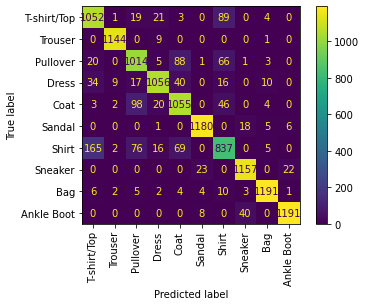

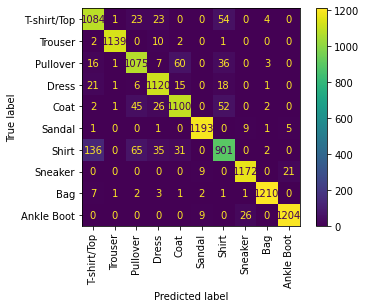

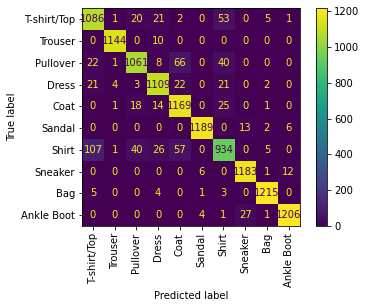

In [ ]:
# plot confusion matrices
classes = list(lab_dict.values())
#plt.figure(figsize = (15,5))
for it, pred in enumerate(preds):
  print(f"\n confusion matrix for model {mods[it]}")
  ConfusionMatrixDisplay.from_predictions(y_true = pred[0],y_pred = pred[1],
                                        display_labels = classes,
                                        xticks_rotation = "vertical")
  save_lab = "plots/confusion_matrix_"+str(mods[it])+".png"
  plt.savefig(save_lab,dpi = 500)
plt.show()

In [ ]:
print("The winner is: ConvNet with augmented data.")

The winner is: ConvNet with augmented data.


## Visualise filters and feature maps for best model


In [ ]:
# load the best model
train_loss, train_acc, val_loss, val_acc = np.load("results/conv_net_aug_res.npy")
conv_net_aug = ConvNet()
state_conv_net = torch.load("cl_checkpoints/cl_conv_aug_checkpoint.pt", map_location = device)
conv_net_aug.load_state_dict(state_conv_net)

<All keys matched successfully>

First layer filters



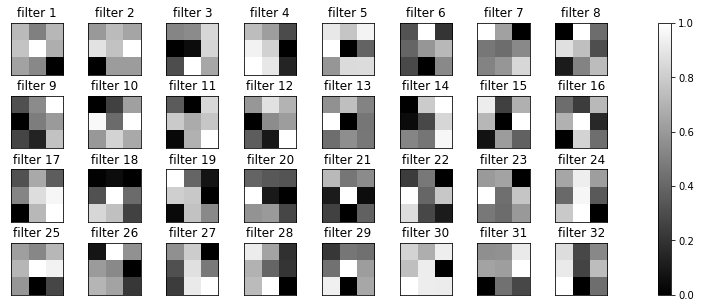

In [ ]:
def norm_min_max(kernel):
  return((kernel - kernel.min())/(kernel.max() - kernel.min()))
fig, ax = plt.subplots(4,8, figsize = (18,5),
                       subplot_kw={'xticks': [], 'yticks': []})
it = 0
for j in ax.reshape(-1):
  kernel = conv_net_aug.conv1[0].weight[it].detach().cpu().numpy().reshape(3,3)
  kernel = norm_min_max(kernel)
  _ = j.imshow(kernel,cmap='gray')
  j.set_title('filter '+str(it+1))
  it += 1
plt.subplots_adjust(wspace=-0.7, hspace=0.4)
plt.colorbar(_,ax=ax.ravel().tolist())
#plt.suptitle("First Layer Filters")
print("First layer filters\n")
plt.savefig("plots/filters.png", dpi = 500)
plt.show()

In [ ]:
acts = {}
def get_activation(name):
  def hook(layer,input,output):
    acts[name] = output.detach().cpu().numpy()
  return hook
img_index = 13
conv1_hook = conv_net_aug.conv1.register_forward_hook(get_activation('conv1'))
conv2_hook = conv_net_aug.conv2.register_forward_hook(get_activation('conv2'))
conv3_hook = conv_net_aug.conv3.register_forward_hook(get_activation('conv3'))
conv_net_aug.to(device)
conv_net_aug.eval()
with torch.no_grad():
  img, cl = next(iter(val_loader))
  _ = conv_net_aug(img[img_index].unsqueeze(0).to(device))
conv1_hook.remove()
conv2_hook.remove()
conv3_hook.remove()

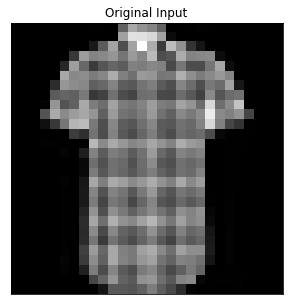

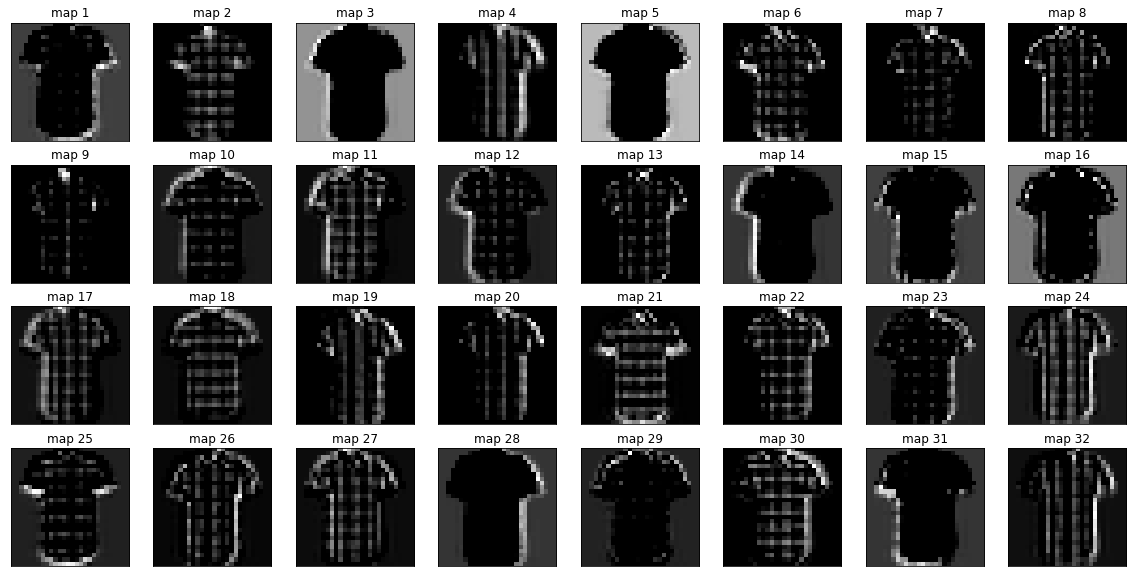

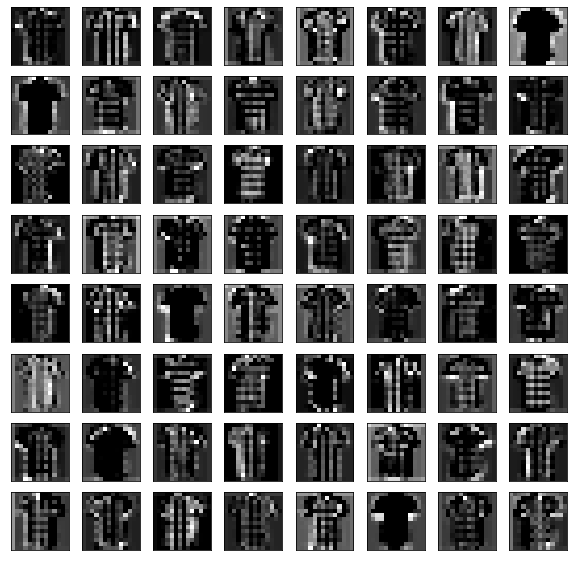

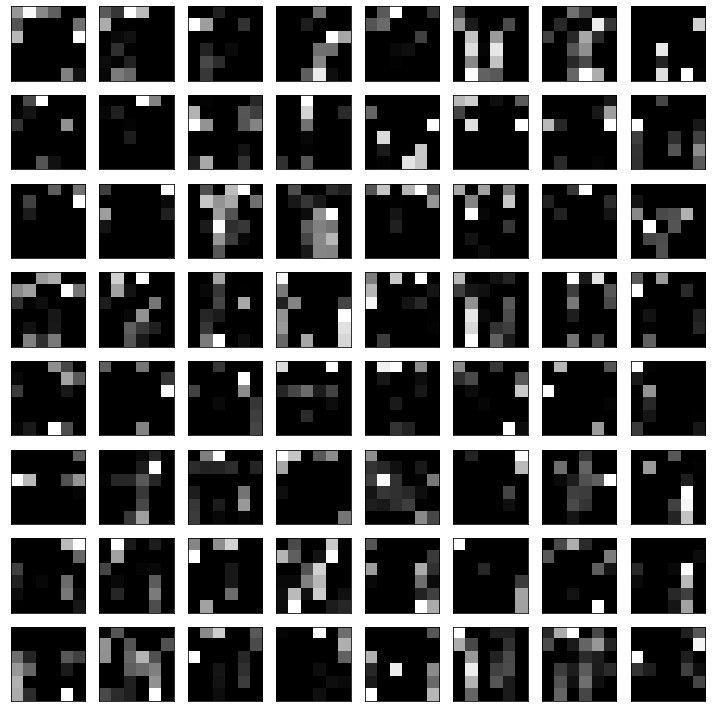

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(img[img_index].view(28,28),cmap = 'gray')
plt.title("Original Input")
plt.xticks([])
plt.yticks([])
plt.savefig("plots/cl_original_input.png", dpi = 500)

fig, ax = plt.subplots(4,8,figsize = (20,10),
                       subplot_kw={'xticks': [], 'yticks': []})
it = 0
for j in ax.reshape(-1):
  _ = j.imshow(acts['conv1'][0][it], cmap = 'gray')
  j.set_title('map '+str(it+1))
  it += 1
plt.savefig("plots/cl_first_layer_activations.png", dpi = 500)

fig2, ax2 = plt.subplots(8,8,figsize = (10,10),
                         subplot_kw ={'xticks':[], 'yticks':[]})
it = 0
for j in ax2.reshape(-1):
  _ = j.imshow(acts['conv2'][0][it], cmap = 'gray')
  it += 1
plt.savefig("plots/cl_second_layer_activations.png", dpi = 500)

fig3, ax3 = plt.subplots(8,8,figsize = (10,10),
                         subplot_kw ={'xticks':[], 'yticks':[]})
it = 0
for j in ax3.reshape(-1):
  _ = j.imshow(acts['conv3'][0][it], cmap = 'gray')
  it += 1
plt.savefig("plots/cl_third_layer_activations.png", dpi = 500)

plt.tight_layout()
plt.show()

## Final Accuracy on the test set

In [ ]:
# load the best model
conv_net_aug = ConvNet()
state_conv_net = torch.load("cl_checkpoints/cl_conv_aug_checkpoint.pt", map_location = device)
conv_net_aug.load_state_dict(state_conv_net)

<All keys matched successfully>

In [ ]:
test_set_predictions = []
classes = list(lab_dict.values())
conv_net_aug.to(device)
y_true, y_hat = predict_cl(test_loader, conv_net_aug, device)

In [ ]:
print("Classification report of conv_net_aug on the test set\n")
print(classification_report(y_true = y_true, y_pred = y_hat, digits = 4, target_names = classes))

Classification report of conv_net_aug on the test set

              precision    recall  f1-score   support

 T-shirt/Top     0.8713    0.9140    0.8921      1000
     Trouser     0.9980    0.9890    0.9935      1000
    Pullover     0.9216    0.8930    0.9071      1000
       Dress     0.9392    0.9270    0.9331      1000
        Coat     0.8624    0.9460    0.9022      1000
      Sandal     0.9939    0.9840    0.9889      1000
       Shirt     0.8493    0.7550    0.7994      1000
     Sneaker     0.9654    0.9760    0.9707      1000
         Bag     0.9745    0.9920    0.9832      1000
  Ankle Boot     0.9760    0.9750    0.9755      1000

    accuracy                         0.9351     10000
   macro avg     0.9351    0.9351    0.9346     10000
weighted avg     0.9351    0.9351    0.9346     10000



In [ ]:
# prepare classification report for report
class_report = pd.DataFrame(classification_report(y_true = y_true, y_pred = y_hat, digits = 4, target_names = classes, output_dict = True)).T
class_report = class_report.iloc[:,[0,1,3]]
#print(class_report.to_latex(index = True, caption = "Classification report on test set", label = 'tab:class_report_test', float_format = "%.4f"))

\begin{table}
\centering
\caption{Classification report on test set}
\label{tab:class_report_test}
\begin{tabular}{lrrr}
\toprule
{} &  precision &  recall &    support \\
\midrule
T-shirt/Top  &     0.8713 &  0.9140 &  1000.0000 \\
Trouser      &     0.9980 &  0.9890 &  1000.0000 \\
Pullover     &     0.9216 &  0.8930 &  1000.0000 \\
Dress        &     0.9392 &  0.9270 &  1000.0000 \\
Coat         &     0.8624 &  0.9460 &  1000.0000 \\
Sandal       &     0.9939 &  0.9840 &  1000.0000 \\
Shirt        &     0.8493 &  0.7550 &  1000.0000 \\
Sneaker      &     0.9654 &  0.9760 &  1000.0000 \\
Bag          &     0.9745 &  0.9920 &  1000.0000 \\
Ankle Boot   &     0.9760 &  0.9750 &  1000.0000 \\
accuracy     &     0.9351 &  0.9351 &     0.9351 \\
macro avg    &     0.9351 &  0.9351 & 10000.0000 \\
weighted avg &     0.9351 &  0.9351 & 10000.0000 \\
\bottomrule
\end{tabular}
\end{table}



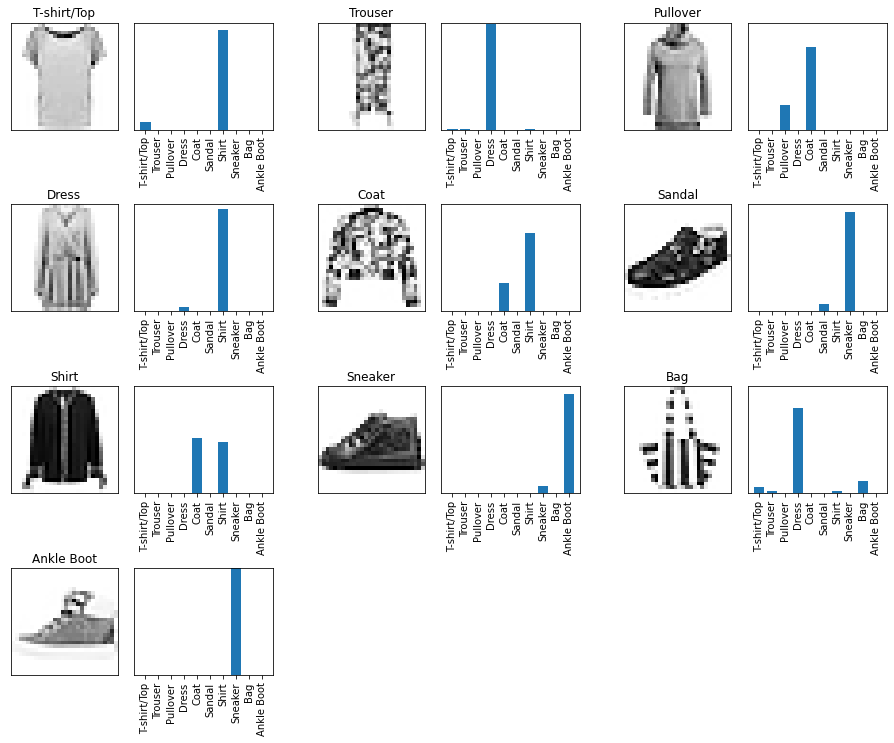

In [ ]:
# for each class plot one randomly sampled image where it missclassified
torch.manual_seed(123)
np.random.seed(123)
missclassified_mask = (y_true != y_hat)
test_dataset_misscl = copy.deepcopy(test_dataset)
test_dataset_misscl.data = test_dataset_misscl.data[missclassified_mask]
test_dataset_misscl.targets = test_dataset_misscl.targets[missclassified_mask]

fig = plt.figure(figsize=(16,12))
outer = gridspec.GridSpec(4, 3, wspace=0.1, hspace=0.7)

labs = list(lab_dict.values())
x = range(len(labs))

for i in range(12):
    img, target = sample_random_cl(i,test_dataset_misscl)
    y_hat_plt = predict_soft(img,conv_net_aug,device)

    inner = gridspec.GridSpecFromSubplotSpec(1, 2,
                    subplot_spec=outer[i], wspace=0, hspace=0)
    
    ax_r = plt.Subplot(fig,inner[1])
    ax_r.set_yticks([])
    ax_r.bar(x = x, height = y_hat_plt[0])
    ax_r.set_ylim((0,1))
    ax_r.set_xticks(x)
    ax_r.set_xticklabels(labs, rotation = 90)
    fig.add_subplot(ax_r)

    ax_l = plt.Subplot(fig,inner[0])
    ax_l.imshow(img.view(28,28),cmap="Greys")
    ax_l.set_xticks([])
    ax_l.set_yticks([])
    ax_l.set_title(lab_dict[int(target)])
    fig.add_subplot(ax_l)
    
    if i == 9:
      break
fig.savefig("plots/misclassified_imgs.png", dpi = 500)
fig.show()